In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np


from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
import torch
import matplotlib.pyplot as plt
import time
import cv2
import natsort

In [83]:
if not os.path.exists("pytorch_unet.py"):
    if not os.path.exists("pytorch_unet"):
        !git clone https://github.com/usuyama/pytorch-unet.git

fatal: destination path 'pytorch-unet' already exists and is not an empty directory.


In [2]:
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True):
        super().__init__()

        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(
            f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch

    def combine_files(self, r_file: Path, g_dir, b_dir, nir_dir, gt_dir):

        files = {'red': r_file,
                 'green': g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'),
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}

        return files

    def __len__(self):

        return len(self.files)

    def open_as_array(self, idx, invert=False, include_nir=False):

        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                            ], axis=2)

        if include_nir:
            nir = np.expand_dims(
                np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)

        if invert:
            raw_rgb = raw_rgb.transpose((2, 0, 1))

        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)

    def open_mask(self, idx, add_dims=False):

        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask == 255, 1, 0)

        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask

    def __getitem__(self, idx):

        x = torch.tensor(self.open_as_array(
            idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False),
                         dtype=torch.torch.int64)

        return x, y

In [3]:
base_path = Path('./38-cloud/38-Cloud_training/')
data = CloudDataset(base_path/'train_red',
                    base_path/'train_green',
                    base_path/'train_blue',
                    base_path/'train_nir',
                    base_path/'train_gt')
len(data)

8400

In [4]:
x, y = data[1000]
x.shape, y.shape


(torch.Size([4, 384, 384]), torch.Size([384, 384]))

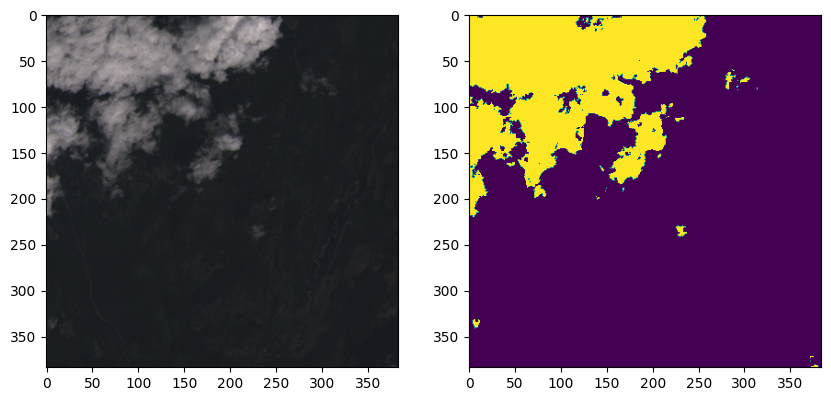

In [5]:
# visualize raw image and ground truth
image_index = 477

fig, ax = plt.subplots(1, 2, figsize=(10, 9))
ax[0].imshow(data.open_as_array(image_index))
ax[1].imshow(data.open_mask(image_index))


### Converter to yolo format


In [3]:
path = '38-cloud/38-Cloud_test/'
r_dir = f'{path}test_red/red_patch_175_9_by_7_LC08_L1TP_050024_20160520_20170324_01_T1.TIF'
g_dir = f'{path}test_green/green_patch_175_9_by_7_LC08_L1TP_050024_20160520_20170324_01_T1.TIF'
b_dir = f'{path}test_blue/blue_patch_175_9_by_7_LC08_L1TP_050024_20160520_20170324_01_T1.TIF'
nir_dir = f'{path}test_nir/nir_patch_175_9_by_7_LC08_L1TP_050024_20160520_20170324_01_T1.TIF'

canal_vermelho = cv2.imread(r_dir, cv2.IMREAD_GRAYSCALE)
canal_verde = cv2.imread(g_dir, cv2.IMREAD_GRAYSCALE)
canal_azul = cv2.imread(b_dir, cv2.IMREAD_GRAYSCALE)
canal_infravermelho = cv2.imread(nir_dir, cv2.IMREAD_GRAYSCALE)

# Combine os canais em uma única imagem colorida
imagem_colorida = cv2.merge((canal_azul, canal_verde, canal_vermelho))

# Exiba a imagem resultante
cv2.imwrite('imagem_unida.png', imagem_colorida)

# cv2.waitKey(0)
# cv2.destroyAllWindows()

True

In [6]:
from rasterio import features

def create_label(image_path, label_path):
    arr = np.asarray(Image.open(image_path))
    # There may be a better way to do it, but this is what I have found so far
    shapes = list(features.shapes(arr, mask=(arr > 0)))
    if shapes:
        cords = list(features.shapes(arr, mask=(arr >0)))[0][0]['coordinates'][0]
    else:
        cords = []
    label_line = '0 ' + ' '.join([f'{int(cord[0])/arr.shape[0]} {int(cord[1])/arr.shape[1]}' for cord in cords])

    label_path.parent.mkdir( parents=True, exist_ok=True )
    with label_path.open('w') as f:
        f.write(label_line)


In [4]:
# split train images in 60% train, 20% valid, 20% test
# train, valid, test = np.split(data, [int(.6*len(data)), int(.8*len(data))])   
data_path = os.listdir('./38-cloud/38-Cloud_training/train_red')
data_path = natsort.natsorted(data_path)
train, valid, test = np.split(data_path, [int(.6*len(data_path)), int(.8*len(data_path))])   

In [14]:
train

array(['red_patch_1_1_by_1_LC08_L1TP_002053_20160520_20170324_01_T1.TIF',
       'red_patch_1_1_by_1_LC08_L1TP_002054_20160520_20170324_01_T1.TIF',
       'red_patch_1_1_by_1_LC08_L1TP_011002_20160620_20170323_01_T1.TIF',
       ...,
       'red_patch_281_12_by_17_LC08_L1TP_011002_20160620_20170323_01_T1.TIF',
       'red_patch_281_13_by_5_LC08_L1TP_044010_20160220_20170224_01_T1.TIF',
       'red_patch_281_13_by_5_LC08_L1TP_059014_20160620_20170221_01_T1.TIF'],
      dtype='<U67')

In [ ]:
path = '38-cloud/38-Cloud_test/'
r_dir = f'{path}test_red/red_patch_175_9_by_7_LC08_L1TP_050024_20160520_20170324_01_T1.TIF'
g_dir = f'{path}test_green/green_patch_175_9_by_7_LC08_L1TP_050024_20160520_20170324_01_T1.TIF'
b_dir = f'{path}test_blue/blue_patch_175_9_by_7_LC08_L1TP_050024_20160520_20170324_01_T1.TIF'
nir_dir = f'{path}test_nir/nir_patch_175_9_by_7_LC08_L1TP_050024_20160520_20170324_01_T1.TIF'

canal_vermelho = cv2.imread(r_dir, cv2.IMREAD_GRAYSCALE)
canal_verde = cv2.imread(g_dir, cv2.IMREAD_GRAYSCALE)
canal_azul = cv2.imread(b_dir, cv2.IMREAD_GRAYSCALE)
canal_infravermelho = cv2.imread(nir_dir, cv2.IMREAD_GRAYSCALE)

# Combine os canais em uma única imagem colorida
imagem_colorida = cv2.merge((canal_azul, canal_verde, canal_vermelho))

# Exiba a imagem resultante
cv2.imwrite('imagem_unida.png', imagem_colorida)

# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [74]:
train_path = './38-cloud/38-Cloud_training/'
for i,image in enumerate(test):

    r_dir = f'{train_path}train_red/'
    g_dir = f'{train_path}train_green/'
    b_dir = f'{train_path}train_blue/'
    nir_dir = f'{train_path}train_nir/'
    
    g_dir = g_dir+image.replace('red', 'green')
    b_dir = b_dir+image.replace('red', 'blue')
    nir_dir = nir_dir+image.replace('red', 'nir')

    canal_vermelho = cv2.imread(r_dir+image, cv2.IMREAD_GRAYSCALE)
    canal_verde = cv2.imread(g_dir, cv2.IMREAD_GRAYSCALE)
    canal_azul = cv2.imread(b_dir, cv2.IMREAD_GRAYSCALE)
    canal_infravermelho = cv2.imread(nir_dir, cv2.IMREAD_GRAYSCALE)


    # Combine os canais em uma única imagem colorida
    imagem_colorida = cv2.merge((canal_azul, canal_verde, canal_vermelho))

    # Exiba a imagem resultante
    cv2.imwrite(f'./datasets/test/images/{image}', imagem_colorida)

In [45]:
mask_path = './38-cloud/38-Cloud_training/train_gt/'
for i,image in enumerate(valid):
    
    gt_dir = mask_path+image.replace('red', 'gt')

    imagem = np.array(Image.open(gt_dir))

    np.savetxt(f'./datasets/val/labels/{image}___.txt', imagem, fmt='%d')
    break

    coordenadas = np.argwhere(imagem == 255)

    altura, largura = 384, 384

    coordenadas_normalizadas = coordenadas.astype(float) / np.array([largura, altura])

    class_index = 0

    output_string = f"{class_index} {' '.join(map(str, coordenadas_normalizadas.flatten()))}"

    with open(f'./datasets/val/labels/{image}.txt', "w") as arquivo_saida:
        arquivo_saida.write(output_string)

In [30]:
gt_dir = mask_path+valid[6].replace('red', 'gt')

imagem = np.array(Image.open(gt_dir))

np.savetxt(f'./datasets/val/labels/aaaa___.txt', imagem, fmt='%d')




In [31]:
import cv2
import numpy as np

# Carregue a máscara de imagem (substitua pelo seu caminho de arquivo)
mask = cv2.imread(mask_path+valid[6].replace('red', 'gt'), cv2.IMREAD_GRAYSCALE)

# Encontre os contornos dos objetos na máscara
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Crie uma lista para armazenar as posições
positions = []

# Para cada objeto encontrado
for contour in contours:
    # Extraia as coordenadas x, y do contorno
    coordinates = contour.squeeze()
    
    # Adicione as coordenadas à lista de posições
    positions.append(coordinates)

# Transforme a lista de posições em uma string no formato desejado (classe index fixada em 0)
positions_str = '\n'.join(['0 ' + ' '.join(map(str, coords.flatten())) for coords in positions])

# Salve a string em um arquivo (substitua pelo caminho desejado)
with open('posicoes.txt', 'w') as file:
    file.write(positions_str)




Posições salvas em 'posicoes.txt'


In [53]:
mask_path = './38-cloud/38-Cloud_training/train_gt/'
for i,image in enumerate(valid):
    mask = cv2.imread(mask_path+image.replace('red', 'gt'), cv2.IMREAD_GRAYSCALE)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    positions = []

    for contour in contours:
        coordinates = contour.squeeze()
        
        positions.append(coordinates)
        
    positions_str = '\n'.join(['0 ' + ' '.join(map(str, coords.flatten())) for coords in positions])

    with open(f'./datasets/val/labels/{image.replace(".TIF","")}.txt', "w") as file:
        file.write(positions_str)


In [ ]:
mask[height - points[1::2], points[::2]] = 255

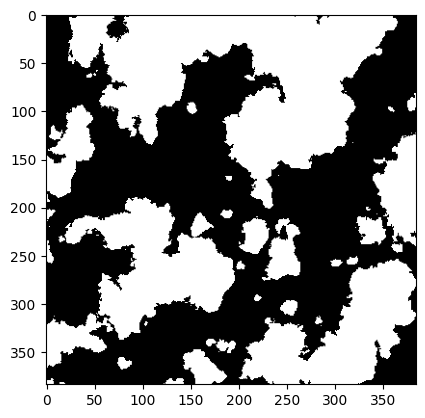

In [ ]:
mask = cv2.imread(mask_path + valid[6].replace('red', 'gt'), cv2.IMREAD_GRAYSCALE)

# Inverter verticalmente a máscara
# mask = cv2.flip(mask, 0)

# Encontre os contornos na máscara
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Criar uma imagem preta como fundo
height, width = mask.shape
mask_result = np.zeros((height, width), dtype=np.uint8)

# Preencher a máscara corretamente
for contour in contours:
    cv2.fillPoly(mask_result, [contour], 255)

# Plotar a imagem resultante
plt.imshow(mask_result, cmap='gray')
plt.show()

In [ ]:
# # Lê as informações do arquivo de texto
# with open('arquivo.txt', 'r') as file:
#     lines = file.readlines()

# # Dimensões da imagem original (substitua pelas dimensões reais da sua imagem)
# image_width = 384
# image_height = 384

# # Lista para armazenar as informações no formato YOLO
# yolo_annotations = []

# for line in lines:
#     values = line.strip().split()
#     class_index = int(values[0])
#     coordinates = list(map(float, values[1:]))
    
#     # Normalize as coordenadas
#     x_center = (coordinates[0] + coordinates[2]) / (2 * image_width)
#     y_center = (coordinates[1] + coordinates[3]) / (2 * image_height)
#     width = (coordinates[2] - coordinates[0]) / image_width
#     height = (coordinates[3] - coordinates[1]) / image_height
    
#     # Formato YOLO: <object-class> <x-center> <y-center> <width> <height>
#     yolo_format = f"{class_index} {x_center} {y_center} {width} {height}"
    
#     yolo_annotations.append(yolo_format)

# # Escreva as informações normalizadas no arquivo de saída
# with open('caminho/para/saida.txt', 'w') as output_file:
#     for annotation in yolo_annotations:
#         output_file.write(annotation + '\n')


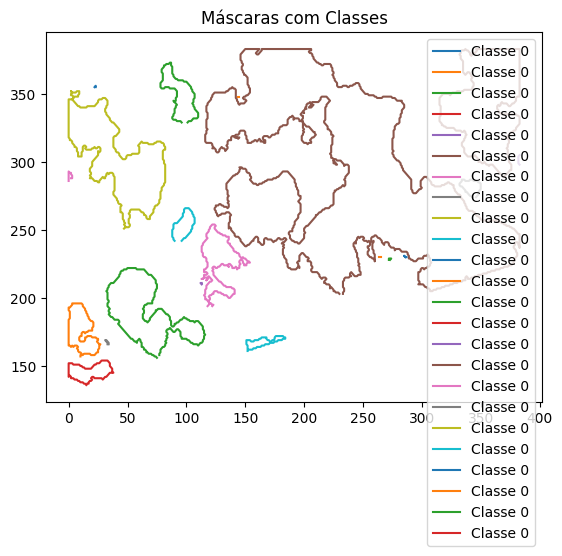

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Leitura das informações do arquivo de texto
with open('datasets/train/labels/red_patch_6_1_by_6_LC08_L1TP_032029_20160420_20170223_01_T1.txt', 'r') as file:
    lines = file.readlines()

# Processamento das informações para obter as coordenadas
masks = []
for line in lines:
    values = line.strip().split()
    class_index = int(values[0])
    coordinates = list(map(float, values[1:]))
    masks.append((class_index, coordinates))

# Crie uma figura para exibir as máscaras
fig, ax = plt.subplots()

# Plote cada máscara
for class_index, coordinates in masks:
    x = coordinates[::2]  # Coordenadas x
    y = coordinates[1::2]  # Coordenadas y
    ax.plot(x, y, label=f'Classe {class_index}')

# Configure o título e a legenda
ax.set_title('Máscaras com Classes')
ax.legend()

# Exiba a figura
plt.show()


In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Ler a máscara do arquivo de texto
with open('datasets/train/labels/red_patch_6_1_by_6_LC08_L1TP_032029_20160420_20170223_01_T1.txt', 'r') as file:
    mask_data = file.readline().split()



# Inicializar uma imagem preta como fundo
width = 1024  # Supondo que a largura da imagem seja 1024
background = np.zeros((width, width), dtype=np.uint8)

# Loop através das linhas do arquivo para ler os pontos da máscara
for line in mask_data:
    mask_values = list(map(int, line.split()))
    
    # O primeiro valor é a classe, e os valores restantes são coordenadas (x, y)
    class_index = mask_values[0]
    points = mask_values[1:]
    
    # Espelhar os valores horizontalmente, se necessário
    mirrored_points = [width - points[i] if i % 2 == 0 else points[i] for i in range(len(points))]
    
    # Converter os pontos em um formato adequado para plotagem
    mask_coordinates = np.array(mirrored_points).reshape(-1, 2)
    
    # Desenhar a máscara na imagem de fundo
    background = cv2.fillPoly(background, [mask_coordinates], color=(255, 255, 255))

# Plotar a imagem com as máscaras
plt.figure(figsize=(6, 6))
plt.imshow(background, cmap='gray')
plt.show()


error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\drawing.cpp:2431: error: (-215:Assertion failed) p.checkVector(2, CV_32S) >= 0 in function 'cv::fillPoly'


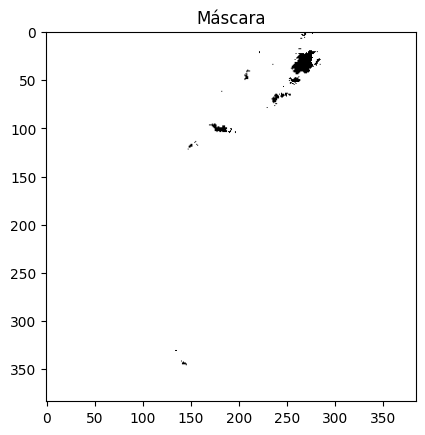

In [25]:
image = 'red_patch_281_13_by_17_LC08_L1TP_061017_20160720_20170223_01_T1.TIF'

# Diretório de saída
output_directory = './datasets/val/labels/'

# Leia o arquivo de texto com as coordenadas normalizadas
with open(os.path.join(output_directory, f'{image}.txt'), "r") as arquivo_entrada:
    linha = arquivo_entrada.readline().strip().split()
    class_index = int(linha[0])
    coordenadas_normalizadas = [float(coord) for coord in linha[1:]]

# Tamanho da imagem
altura, largura = 384, 384

# Crie uma matriz de zeros para representar a máscara
mascara = np.zeros((altura, largura), dtype=np.uint8)

# Preencha a máscara com os valores das coordenadas normalizadas
for i in range(0, len(coordenadas_normalizadas), 2):
    x = int(coordenadas_normalizadas[i] * largura)
    y = int(coordenadas_normalizadas[i+1] * altura)
    mascara[y, x] = 255  # Defina o valor para 255 nas coordenadas

# Plote a máscara
plt.imshow(mascara, cmap='gray')
plt.title('Máscara')
plt.show()

In [ ]:
for images_dir_path in [Path(f'datasets/{x}/images') for x in ['train', 'val', 'test']]:
    for img_path in images_dir_path.iterdir():
        label_path = img_path.parent.parent / 'labels' / f'{img_path.stem}.txt'
        label_line = create_label(img_path, label_path)

In [21]:
images_dir_path = Path("38-cloud/38-Cloud_training/train_gt/")
for img_path in images_dir_path.iterdir():
        label_path = img_path.parent.parent / 'labels' / f'{img_path.stem}.txt'
        label_line = create_label(img_path, label_path)

In [ ]:
path = '38-cloud/38-Cloud_test/'
r_dir = f'{path}test_red/red_patch_175_9_by_7_LC08_L1TP_050024_20160520_20170324_01_T1.TIF'
g_dir = f'{path}test_green/green_patch_175_9_by_7_LC08_L1TP_050024_20160520_20170324_01_T1.TIF'
b_dir = f'{path}test_blue/blue_patch_175_9_by_7_LC08_L1TP_050024_20160520_20170324_01_T1.TIF'
nir_dir = f'{path}test_nir/nir_patch_175_9_by_7_LC08_L1TP_050024_20160520_20170324_01_T1.TIF'

canal_vermelho = cv2.imread(r_dir, cv2.IMREAD_GRAYSCALE)
canal_verde = cv2.imread(g_dir, cv2.IMREAD_GRAYSCALE)
canal_azul = cv2.imread(b_dir, cv2.IMREAD_GRAYSCALE)
canal_infravermelho = cv2.imread(nir_dir, cv2.IMREAD_GRAYSCALE)

# Combine os canais em uma única imagem colorida
imagem_colorida = cv2.merge((canal_azul, canal_verde, canal_vermelho))

# Exiba a imagem resultante
cv2.imshow('Imagem Colorida', imagem_colorida)
cv2.imwrite('imagem_unida.png', imagem_colorida)

In [22]:
yaml_content = f'''
train: train/images
val: val/images
test: test/images

names: ['circle']
    '''
    
with Path('data.yaml').open('w') as f:
    f.write(yaml_content)

8400

8400

### Using U-NET


In [6]:
train_dataset, valid_dataset = torch.utils.data.random_split(
    data, (6000, 2400))

In [9]:
train_dataload = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_dataload = DataLoader(valid_dataset, batch_size=8, shuffle=True)


In [10]:
xb, yb = next(iter(train_dataload))
xb.shape, yb.shape


(torch.Size([8, 4, 384, 384]), torch.Size([8, 384, 384]))

In [2]:
from torch import nn


class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels,
                            kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels,
                            kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                               torch.nn.BatchNorm2d(out_channels),
                               torch.nn.ReLU(),
                               torch.nn.Conv2d(
                                   out_channels, out_channels, kernel_size, stride=1, padding=padding),
                               torch.nn.BatchNorm2d(out_channels),
                               torch.nn.ReLU(),
                               torch.nn.ConvTranspose2d(
                                   out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                               )
        return expand


unet = UNET(4, 2)

In [12]:
xb, yb = next(iter(train_dataload))
xb.shape, yb.shape


(torch.Size([8, 4, 384, 384]), torch.Size([8, 384, 384]))

In [13]:
pred = unet(xb)
pred.shape


torch.Size([8, 2, 384, 384])

In [14]:


if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name NVIDIA GeForce RTX 3060


In [114]:
import time
from IPython.display import clear_output

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 100 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    



In [18]:
def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()

In [20]:
import time
import torch
from IPython.display import clear_output

def train_with_early_stop(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=100, patience=10, checkpoint_path='checkpoint.pth'):
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []

    best_acc = 0.0
    early_stop_counter = 0  # Counter to track early stopping

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set training mode = True
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluation mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # Iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # Forward pass
                if phase == 'train':
                    # Zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # Backward pass
                    loss.backward()
                    optimizer.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # Calculate accuracy
                acc = acc_fn(outputs, y)

                running_acc += acc * dataloader.batch_size
                running_loss += loss * dataloader.batch_size

                if step % 100 == 0:
                    print('Current step: {}  Loss: {:.4f}  Acc: {:.4f}  AllocMem (Mb): {:.2f}'.format(step, loss, acc, torch.cuda.memory_allocated() / 1024 / 1024))

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            train_loss.append(epoch_loss) if phase == 'train' else valid_loss.append(epoch_loss)

            # Check for early stopping
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                early_stop_counter = 0
                # Save the model checkpoint when validation accuracy improves
                torch.save(model.state_dict(), checkpoint_path)
            elif phase == 'valid':
                early_stop_counter += 1

        # Early stopping condition
        if early_stop_counter >= patience:
            print('Early stopping after {} epochs without improvement.'.format(patience))
            break

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return train_loss, valid_loss


In [21]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(unet.parameters(), lr=0.01) 

train_loss, valid_loss = train_with_early_stop(unet, train_dataload, valid_dataload, loss_fn, opt, acc_metric, epochs=100)

Epoch 38/99
----------
valid Loss: 0.1567 Acc: 0.9380
----------
Epoch 39/99
----------
Current step: 100  Loss: 0.1480  Acc: 0.9347  AllocMem (Mb): 44.33


RuntimeError: [enforce fail at ..\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 18874368 bytes.

In [31]:
train_loss = torch.tensor(train_loss)
valid_loss = torch.tensor(valid_loss)

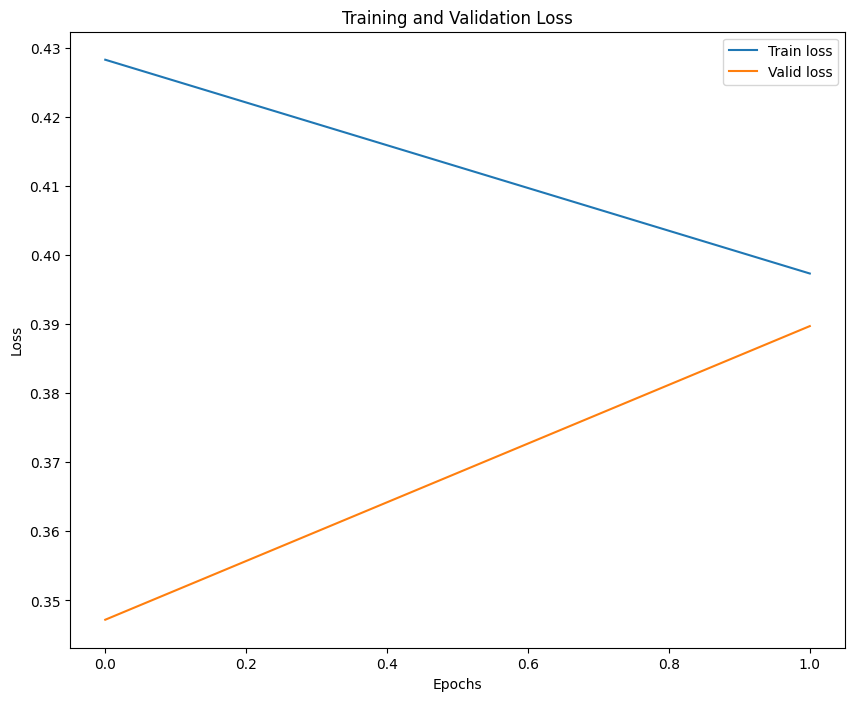

In [32]:
train_loss = np.array(train_loss.cpu())
valid_loss = np.array(valid_loss.cpu())

plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
def batch_to_(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def batch_to_img(xb, idx):
    channels = xb.shape[1]
    img = np.zeros((xb.shape[2], xb.shape[3], channels))
    for c in range(channels):
        img[..., c] = xb[idx, c]
    return img

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [ ]:
unet.eval()

In [35]:
xb, yb = next(iter(train_dataload))

with torch.no_grad():
    predb = unet(xb.cuda())

predb.shape

torch.Size([3, 2, 384, 384])

IndexError: index 3 is out of bounds for dimension 0 with size 3

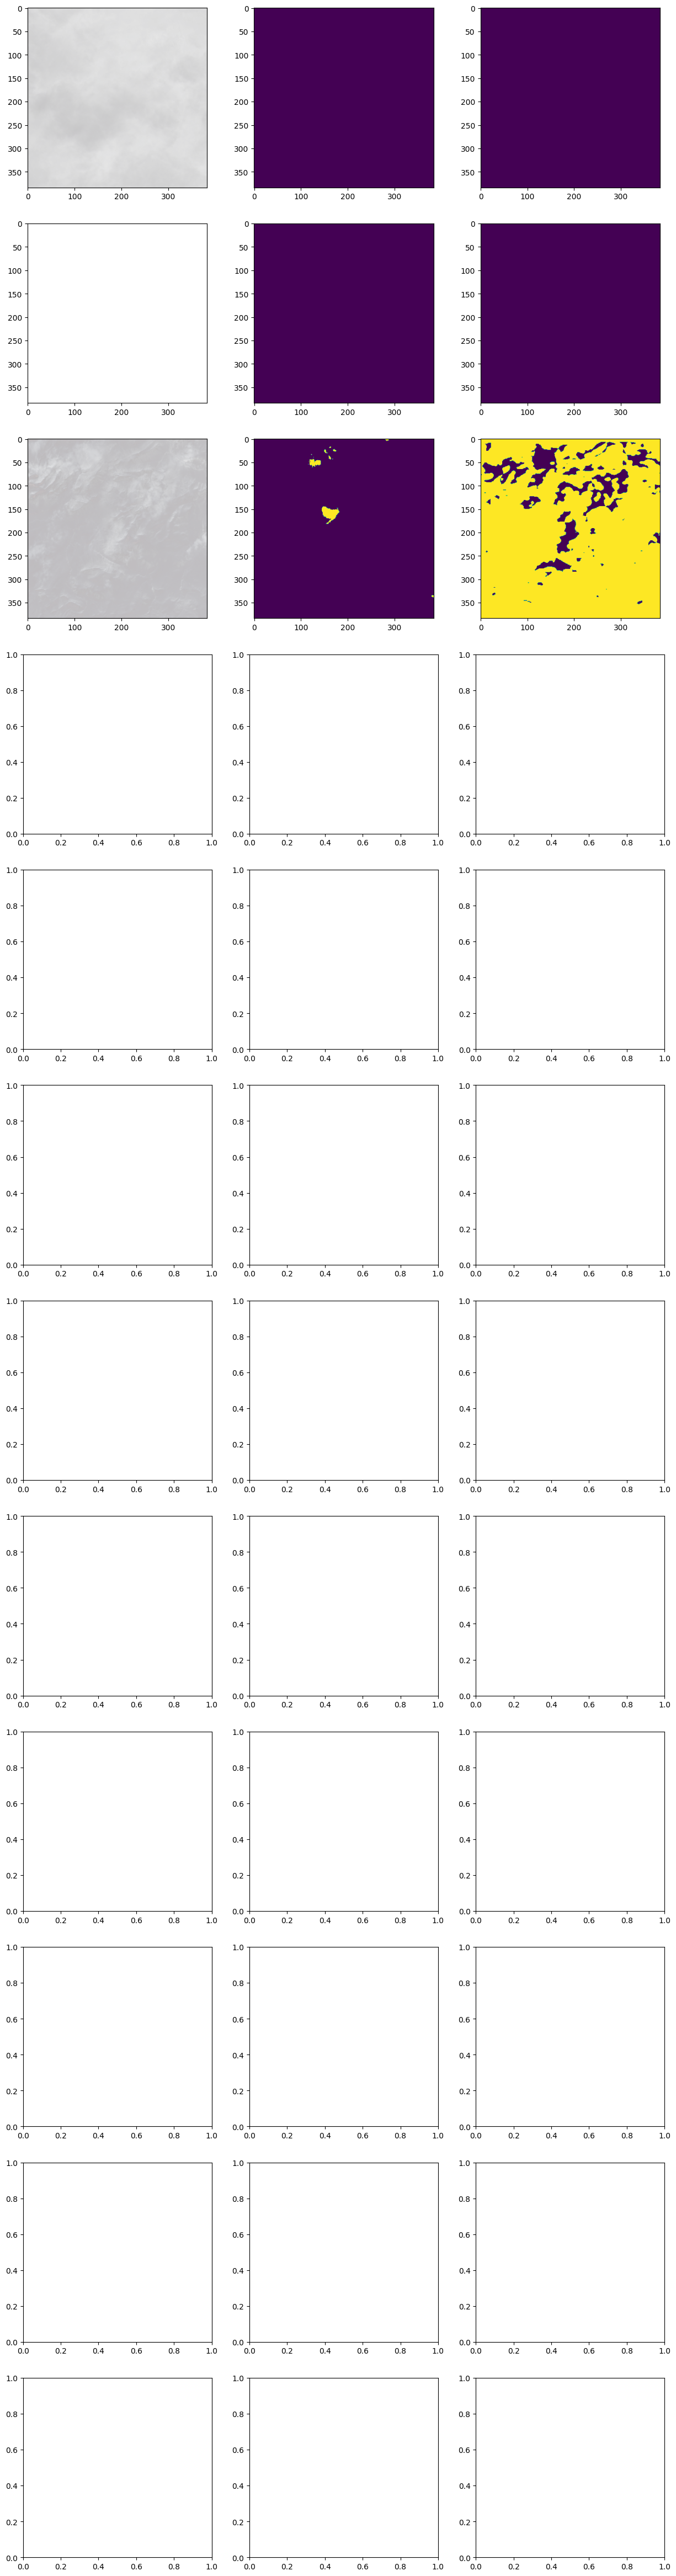

In [38]:
bs = 12
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

### Save model

In [33]:

weights_model = 'modelo_unet.pth'

torch.save(unet.state_dict(), weights_model)


informacoes_salvas = {
    'modelo_state_dict': unet.state_dict(),
    'otimizador_state_dict': opt.state_dict(),
    'loss_train': train_loss,
    'loss_valid': valid_loss,
}

info_model = 'modelo_unet_com_info.pth'

torch.save(informacoes_salvas, info_model)


### Load Model

In [3]:
caminho_arquivo_com_info = 'modelo_unet_com_info.pth'

informacoes_carregadas = torch.load(caminho_arquivo_com_info)

unet_carregado = UNET(4, 2) 

opt = torch.optim.Adam(unet_carregado.parameters(), lr=0.01) 

unet_carregado.load_state_dict(informacoes_carregadas['modelo_state_dict'])

opt.load_state_dict(informacoes_carregadas['otimizador_state_dict'])

# Obter outras informações, como o número de épocas
loss_train = informacoes_carregadas['loss_train']
loss_valid = informacoes_carregadas['loss_valid']

unet_carregado.eval()  # Defina o modelo no modo de avaliação para inferências


FileNotFoundError: [Errno 2] No such file or directory: 'modelo_unet_com_info.pth'

In [8]:
def batch_to_img(xb, idx):
    channels = xb.shape[1]
    img = np.zeros((xb.shape[2], xb.shape[3], channels))
    for c in range(channels):
        img[..., c] = xb[idx, c]
    return img

def predb_to_mask_(predb):
    p = torch.functional.F.softmax(predb)
    return p.argmax(0).cpu()

./38-cloud/38-Cloud_test/test_red/red_patch_175_9_by_7_LC08_L1TP_050024_20160520_20170324_01_T1.TIF
torch.Size([1, 2, 384, 384])


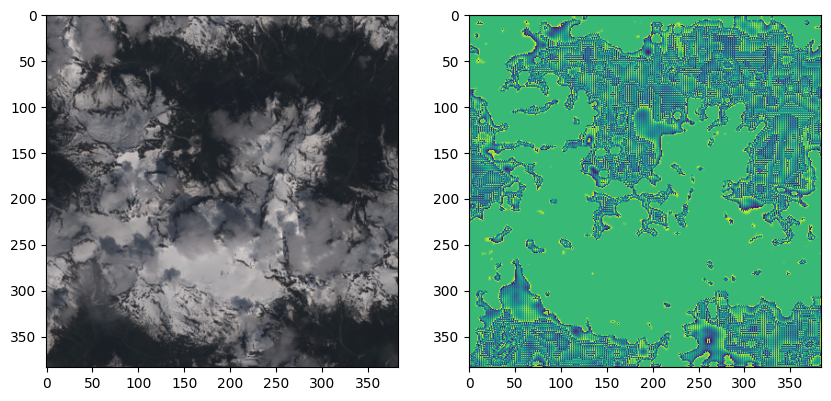

In [9]:
# Carregar os dados de entrada usando a classe CloudDataset
print("./38-cloud/38-Cloud_test/test_red/red_patch_175_9_by_7_LC08_L1TP_050024_20160520_20170324_01_T1.TIF")
path = '38-cloud/38-Cloud_test/'
r_dir = f'{path}test_red/red_patch_175_9_by_7_LC08_L1TP_050024_20160520_20170324_01_T1.TIF'
g_dir = f'{path}test_green/green_patch_175_9_by_7_LC08_L1TP_050024_20160520_20170324_01_T1.TIF'
b_dir = f'{path}test_blue/blue_patch_175_9_by_7_LC08_L1TP_050024_20160520_20170324_01_T1.TIF'
nir_dir = f'{path}test_nir/nir_patch_175_9_by_7_LC08_L1TP_050024_20160520_20170324_01_T1.TIF'

# dataset = CloudDataset(r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True)


red_image = Image.open(r_dir)
green_image = Image.open(g_dir)
blue_image = Image.open(b_dir)



input_tensor = np.stack([red_image, green_image, blue_image], axis=2)

nir_image = Image.open(nir_dir)

nir = np.expand_dims(np.array(nir_image), 2)
input_tensor = np.concatenate([input_tensor, nir], axis=2)


input_tensor = input_tensor.transpose((2, 0, 1))
input_tensor = input_tensor/np.iinfo(input_tensor.dtype).max
input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
input_tensor = input_tensor.unsqueeze(0)


with torch.no_grad():
    output = unet_carregado(input_tensor)

print(output.shape)


# output = output.squeeze(0)
# output = output.cpu().numpy()


# output = (output * 255).astype(np.uint8)  
# output = Image.fromarray(output[0])  


output.save('output.png')

input_image = input_tensor[0, 0:3].cpu().numpy().transpose((1, 2, 0))

fig, ax = plt.subplots(1, 2, figsize=(10, 9))
ax[0].imshow(input_image)
ax[1].imshow(predb_to_mask_(output))
plt.show()